Импорт нужных библиотек

In [241]:

import pandas as pd
import numpy as np
import collections
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score, mean_squared_error

In [242]:
df = pd.read_csv('teams_matches_stats-2 (1).csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.sort_values(by = 'date', ignore_index = 'True', inplace = True)
data1 = df.drop([ 'Opp Formation', 'Formation', 'Captain', 'Referee','result','time','game', 'day', 'venue', 'opponent', 'season','GT', 'Gdiff'], axis = 1)

In [243]:
def getStats(team, date, df = data1):
    srez = df[(df['team']== team)&(df['date'] < date)]
    if 0 < len(srez) < 10:
      stats = srez.drop(['team','date'], axis = 1).sum()/len(srez)
    elif len(srez) >= 10:
      stats = srez.drop(['team','date'], axis = 1)[-10:].sum()/10
    else:
      srez = df[(df['team']== team)&(df['date'] <= date)]
      stats = srez.drop(['team','date'], axis = 1).sum()

    return stats.values.tolist()

In [244]:
seasons = df['season'].unique()

In [245]:
def GetTrain(data):
  features = []
  for i in range(len(data)):
    team1 = getStats(data['team'][i], data['date'][i])
    team2 = getStats(data['opponent'][i], data['date'][i])
    diff = [a - b for a, b in zip(team1, team2)]
    features.append(diff)
  return features

In [246]:

def feature_engineering(df):
    df = df.copy()
    
    df['Possession_Percentage'] = df['Poss'] / 100
    df['Foul_Intensity'] = df['fouls_com'] + df['fouls_drw']
    df['Attack_Efficiency'] = df['GF'] / df['crosses'].replace(0, 1)
    df['Defense_Efficiency'] = df['Tackles.1'] + df['Int']
    df['Yellow_Cards_per_Foul'] = df['yellow'] / (df['fouls_com'] + df['fouls_drw']).replace(0, 1)
    df['Total_Fouls'] = df['fouls_com'] + df['fouls_drw']
    df['Penalty_Efficiency'] = df['Penalty Kicks'] / (df['Penalty Kicks.1'] + df['Penalty Kicks.2'] + df['Penalty Kicks.3']).replace(0, 1)
    

    df['Total_Dismissals'] = df['red'] + df['sec_yel']
    df['Attack_Intensity'] = df['crosses'] + df['Int']
    df['Goals_per_Shot'] = df['GF'] / df['Standard.1'].replace(0, 1)
    df['Pass_Efficiency'] = df['Standard.2'] / df['Standard.1'].replace(0, 1)
    
    

    df['Yellow_Card_Intensity'] = df['yellow'] / (df['fouls_com'] + df['fouls_drw']).replace(0, 1)
    df['Set_Piece_Efficiency'] = df['GF'] / (df['Standard.3'] + df['Standard.4'] + df['Standard.5']).replace(0, 1)
    df['Goals_per_Offside'] = df['GF'] / df['offside'].replace(0, 1)
    df['Set_Piece_Defense_Efficiency'] = df['GA'] / (df['Standard.3'] + df['Standard.4'] + df['Standard.5']).replace(0, 1)
    df['Goals_per_Foul'] = df['GF'] / (df['fouls_com'] + df['fouls_drw']).replace(0, 1)
    df['Shot_Efficiency'] = df['GF'] / df['Standard.1'].replace(0, 1)
    df['Goals_per_Pass'] = df['GF'] / df['Standard.2'].replace(0, 1)
    
    return df


In [255]:
feat_data = pd.DataFrame(GetTrain(feat_data), columns = data1.drop(['team','date'], axis = 1).columns)

In [269]:
feat_data = feature_engineering(feat_data)

In [270]:
x = feat_data

In [271]:

y = list(map((lambda i: 1 if i == 'W' else 0), df['result']))

In [272]:
pd.options.display.max_columns = 100

In [273]:
# x.drop(columns=['GA', 'GF', 'sec_yel'], inplace=True)

In [274]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    train_size=0.8,
                                                    random_state=42)

In [304]:
params = {'learning_rate': 0.02967186558536771, 'iterations': 1305, 
 'l2_leaf_reg': 6.93222488056293,
   'random_strength': 2.7323640366021875, 
   'bagging_temperature': 0.608571900400596}

In [ ]:
from sklearn.model_selection import cross_val_score
import optuna

def objective_catboost(trial):
    max_depth = 4 #trial.suggest_int("max_depth", 3, 5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 1200, 2000)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1, 10)
    random_strength = trial.suggest_float("random_strength", 0, 10)
    bagging_temperature = trial.suggest_float("bagging_temperature", 0, 1)
    # border_count = trial.suggest_int("border_count", 32, 255)

    model = CatBoostClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        bagging_temperature=bagging_temperature,
        # border_count=border_count,
        silent=True
    )

    score = cross_val_score(model, x, y, cv=3, scoring="f1_weighted", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=100)

[I 2025-03-14 21:54:44,177] A new study created in memory with name: no-name-817cbb99-ccc6-414d-a9f0-c65d6b3e57ee
[I 2025-03-14 21:54:49,081] Trial 0 finished with value: 0.6443087246949216 and parameters: {'learning_rate': 0.0033856632234174535, 'n_estimators': 1429, 'l2_leaf_reg': 9.931676116074113, 'random_strength': 4.794492290490082, 'bagging_temperature': 0.9814489182850676}. Best is trial 0 with value: 0.6443087246949216.
[I 2025-03-14 21:54:53,306] Trial 1 finished with value: 0.6140429400517585 and parameters: {'learning_rate': 0.14058538075792706, 'n_estimators': 1242, 'l2_leaf_reg': 9.594846832574008, 'random_strength': 8.444771438867798, 'bagging_temperature': 0.7671162343759188}. Best is trial 0 with value: 0.6443087246949216.
[I 2025-03-14 21:54:59,582] Trial 2 finished with value: 0.6407490619267744 and parameters: {'learning_rate': 0.0018715866415447398, 'n_estimators': 1908, 'l2_leaf_reg': 3.6420247350082, 'random_strength': 7.389592401372057, 'bagging_temperature': 0.

In [306]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
model = CatBoostClassifier(**params,)
model.fit(X_train,y_train)
f1_score(y_pred=model.predict(X_test), y_true=y_test, )

0:	learn: 0.6898336	total: 10.3ms	remaining: 13.5s
1:	learn: 0.6868280	total: 16.3ms	remaining: 10.6s
2:	learn: 0.6839282	total: 21.8ms	remaining: 9.47s
3:	learn: 0.6814714	total: 26.5ms	remaining: 8.62s
4:	learn: 0.6789374	total: 31.2ms	remaining: 8.11s
5:	learn: 0.6761845	total: 35.2ms	remaining: 7.63s
6:	learn: 0.6740253	total: 41.6ms	remaining: 7.72s
7:	learn: 0.6718546	total: 46.8ms	remaining: 7.58s
8:	learn: 0.6698216	total: 51.4ms	remaining: 7.41s
9:	learn: 0.6678531	total: 55.3ms	remaining: 7.16s
10:	learn: 0.6660233	total: 59.6ms	remaining: 7.01s
11:	learn: 0.6644357	total: 63.5ms	remaining: 6.84s
12:	learn: 0.6629952	total: 67.2ms	remaining: 6.67s
13:	learn: 0.6617754	total: 70.8ms	remaining: 6.53s
14:	learn: 0.6604864	total: 75.2ms	remaining: 6.46s
15:	learn: 0.6589828	total: 79.2ms	remaining: 6.38s
16:	learn: 0.6576118	total: 83.8ms	remaining: 6.34s
17:	learn: 0.6563852	total: 88ms	remaining: 6.29s
18:	learn: 0.6551287	total: 92.4ms	remaining: 6.26s
19:	learn: 0.6538764	tot

0.6175478065241845

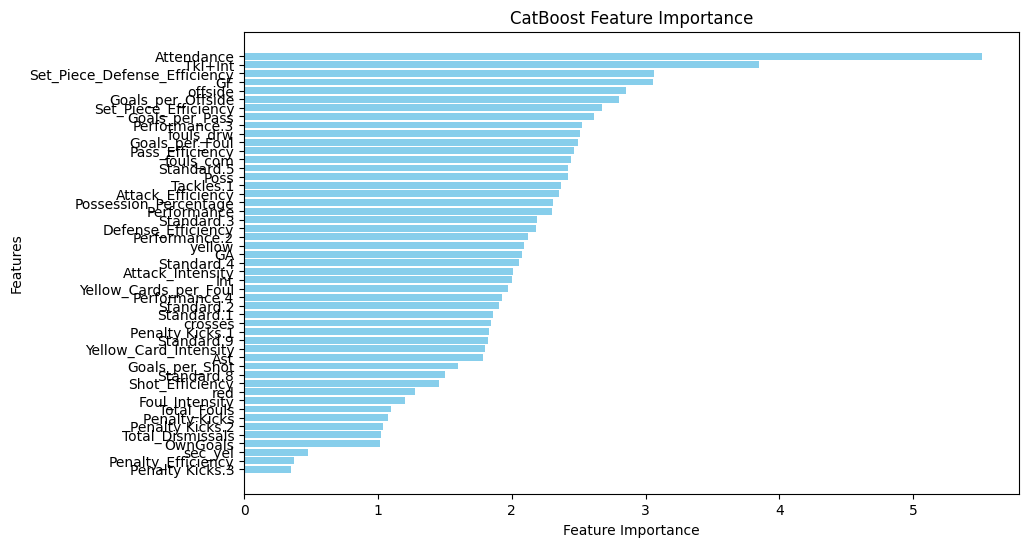

In [ ]:
import matplotlib.pyplot as plt
feature_importance = model.get_feature_importance()

feature_names = x.columns

sorted_indices = np.argsort(feature_importance)[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis() 
plt.show()